# Reinforcement Learning Assignment: Easy21 
## From David Silver's [UCL Course on RL](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html)

In [1]:
from __future__ import division
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## 1. Implementation of Easy21

> You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state s (dealer’s first card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns a sample of the next state s′ (which may be terminal if the game is finished) and reward r. We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

In [2]:
def draw_card(draw_black=False):
    if draw_black:
        color = 1
    else:
        color = np.random.choice([-1, 1], size=1, p=[1/3., 2/3.])[0]
    card_val = np.random.randint(1, 11) * color
    return card_val

def step(s, a):
    '''
    s: state, dealer's first card (1-10) and player's sum (1-21)
    a: action: hit(1) or stick(0)
    '''
    s_prime = list(s)[:] # make a copy
    is_terminated = False
    r = 0

    # dealer action
    if s_prime[0] < 17:
        card = draw_card()
        s_prime[0] += card
        if s_prime[0] > 21 or s_prime[0] < 1: # dealer bust
            r = 1
            
    # player hit action
    if a == 1:
        # player draw a card
        card = draw_card()
        s_prime[1] += card

        if s_prime[1] > 21 or s_prime[1] < 1: # player bust
            r = -1
            is_terminated = True
            
    elif a == 0:
        # player stick
        is_terminated = True
        if s_prime[1] > s_prime[0]:
            r = 1
        elif s_prime[1] < s_prime[0]:
            r = -1
        else:
            r = 0
    # In the next state, the player also only see dealer's first card
    s_prime[0] = s[0]
    return tuple(s_prime), r, is_terminated

In [3]:
# Init game
dealer_first_card = draw_card(draw_black=True)
player_first_card = draw_card(draw_black=True)

s0 = (dealer_first_card, player_first_card)
print 'dealer first card, player sum'
print 's0:', s0

dealer first card, player sum
s0: (9, 10)


In [4]:
def policy(s):
    '''A simple policy that always return hit action (1)'''
    a = 1
    return a

# Simulate one episode:
t = 0
is_terminated = False
while not is_terminated:
    a0 = policy(s0) 
    s1, r, is_terminated = step(s0, a0)
    t += 1
    print 's%d:' % t, s1
    s0 = s1

print 'reward: %d' % r 

s1: (9, 13)
s2: (9, 21)
s3: (9, 24)
reward: -1


In [5]:
def init_game():
    dealer_first_card = draw_card(draw_black=True)
    player_first_card = draw_card(draw_black=True)
    s0 = (dealer_first_card, player_first_card)
    return s0

## 2. Monte-Carlo Control in Easy21

> Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use a time-varying scalar step-size of $\alpha_t = 1/N(s_t,a_t)$ and an ε-greedy exploration strategy with $\epsilon_t = N_0/(N_0 + N(s_t))$, where $N_0 = 100$ is a constant, $N(s)$ is the number of times that state $s$ has been visited, and $N(s,a)$ is the number of times that action a has been selected from state s. Feel free to choose an alternative value for $N_0$, if it helps producing better results. Plot the optimal value function $V^* (s) = max_a Q^* (s, a)$ using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.


### Solution: GLIE Monte-Carlo Control algorithm
- Greedy in the Limit with Infinite Exploration (GLIE)
    + Sample kth episode
    + For each state $S_t$ and action $A_t$ in the episode,    
        update state-action pair counter: $N(S_t, A_t) \leftarrow N(S_t, A_t) + 1$    
        update Q: $Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha_t(G_t - Q(S_t, A_t))$    
    + Improve policy based on new action-value function

In [6]:
Q = defaultdict(lambda: np.zeros(2, dtype=np.float))
N_0 = 100
# state counter N(s)
N_s = Counter()
# state-action pair counter N(s, a)
N_s_a = Counter()

def epsilon_greedy_policy(s, epsilon, Q):
    '''
    Input state s, epsilon, and Q function/table
    return an array (A_probas) of probabilities corresponding to the actions.
    '''
    A_probas = (np.ones(2) / 2) * epsilon # initialize uniformly scaled by epsilon 
    best_action = np.argmax(Q[s]) # find the best action
    A_probas[best_action] += (1.0 - epsilon) 
    return A_probas

In [7]:
# Monte-Carlo Control with epsilon-greedy exploration
n_episodes = 5000

for i in range(n_episodes):
    s0 = init_game()
    t = 0
    is_terminated = False    
    episode = [] # to store (state, action, reward)
    while not is_terminated:
        epsilon = N_0 / (N_0 + N_s[s0])
        A_probas = epsilon_greedy_policy(s0, epsilon, Q)
        a0 = np.random.choice([0, 1], p=A_probas)
        s1, r, is_terminated = step(s0, a0)
        episode.append((s0, a0, r))
        t += 1
        s0 = s1

    if i % 500 == 0:
        print 'episode %d, reward %d' % (i, r)
    # update counters after each episode
    N_s.update([s for s, _, _ in episode])
    N_s_a.update([(s,a) for s, a, _ in episode])
    # find all (state, action) pairs we've visited in this episode
    sa_pairs = set([(s,a) for s, a, _ in episode])
    
    for s, a in sa_pairs:
        # find the first occurance of the (state, action) pair in the episode
        first_occurence_idx = next(i for i, x in enumerate(episode)
                                   if x[0] == s and x[1] == a)
        # rewards since the first occurance
        G = sum([r for _, _, r in episode[first_occurence_idx:]])
        # update Q
        alpha = 1 / N_s_a[(s, a)]
        Q[s][a] += alpha * (G - Q[s][a])

episode 0, reward -1
episode 500, reward 1
episode 1000, reward -1
episode 1500, reward 1
episode 2000, reward 1
episode 2500, reward -1
episode 3000, reward -1
episode 3500, reward -1
episode 4000, reward -1
episode 4500, reward -1


In [8]:
# convert Q to value function
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

In [9]:
Q.items()[:5]

[((7, 3), array([-0.54545455,  0.06896552])),
 ((6, 9), array([ 0.13793103,  0.39897698])),
 ((10, 17), array([ 0.4, -0.5])),
 ((7, 12), array([ 0.23809524,  0.2       ])),
 ((1, 17), array([ 1.        , -0.66666667]))]

In [10]:
V.items()[:5]

[((7, 3), 0.068965517241379309),
 ((6, 9), 0.39897698209718652),
 ((10, 17), 0.40000000000000002),
 ((7, 12), 0.23809523809523808),
 ((1, 17), 1.0)]

In [11]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Dealer Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z, title)


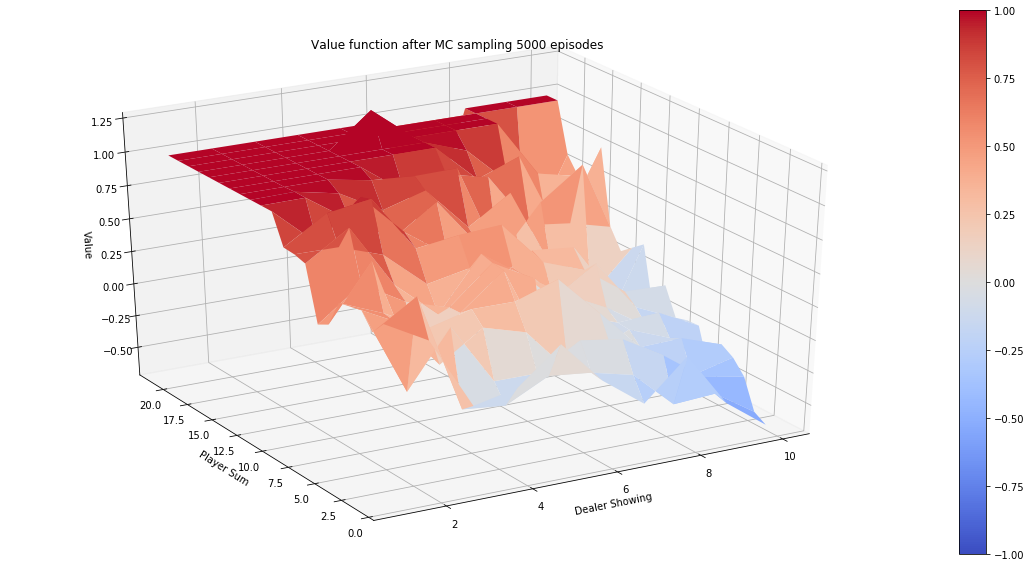

In [12]:
plot_value_function(V, title='Value function after MC sampling %d episodes' % n_episodes)

In [15]:
Q = defaultdict(lambda: np.zeros(2, dtype=np.float))
N_0 = 100
# state counter N(s)
N_s = Counter()
# state-action pair counter N(s, a)
N_s_a = Counter()

# Increase the number of episodes sampled by Monte-Carlo 
n_episodes = 100000
for i in range(n_episodes):
    s0 = init_game()
    t = 0
    is_terminated = False    
    episode = [] # to store (state, action, reward)
    while not is_terminated:
        epsilon = N_0 / (N_0 + N_s[s0])
        A_probas = epsilon_greedy_policy(s0, epsilon, Q)
        a0 = np.random.choice([0, 1], p=A_probas)
        s1, r, is_terminated = step(s0, a0)
        episode.append((s0, a0, r))
        t += 1
        s0 = s1

    if i % 2000 == 0:
        print 'episode %d, reward %d' % (i, r)
    # update counters after each episode
    N_s.update([s for s, _, _ in episode])
    N_s_a.update([(s,a) for s, a, _ in episode])
    # find all (state, action) pairs we've visited in this episode
    sa_pairs = set([(s,a) for s, a, _ in episode])
    
    for s, a in sa_pairs:
        # find the first occurance of the (state, action) pair in the episode
        first_occurence_idx = next(i for i, x in enumerate(episode)
                                   if x[0] == s and x[1] == a)
        # rewards since the first occurance
        G = sum([r for _, _, r in episode[first_occurence_idx:]])
        # update Q
        alpha = 1 / N_s_a[(s, a)]
        Q[s][a] += alpha * (G - Q[s][a])

episode 0, reward 1
episode 2000, reward 1
episode 4000, reward 1
episode 6000, reward 1
episode 8000, reward 1
episode 10000, reward -1
episode 12000, reward -1
episode 14000, reward 1
episode 16000, reward 1
episode 18000, reward 1
episode 20000, reward -1
episode 22000, reward -1
episode 24000, reward -1
episode 26000, reward 1
episode 28000, reward -1
episode 30000, reward 1
episode 32000, reward -1
episode 34000, reward 1
episode 36000, reward 1
episode 38000, reward 1
episode 40000, reward 1
episode 42000, reward 1
episode 44000, reward 1
episode 46000, reward -1
episode 48000, reward -1
episode 50000, reward -1
episode 52000, reward -1
episode 54000, reward -1
episode 56000, reward -1
episode 58000, reward -1
episode 60000, reward -1
episode 62000, reward 1
episode 64000, reward -1
episode 66000, reward 0
episode 68000, reward -1
episode 70000, reward -1
episode 72000, reward 1
episode 74000, reward 1
episode 76000, reward 1
episode 78000, reward 1
episode 80000, reward -1
episo

In [17]:
# convert Q to value function
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

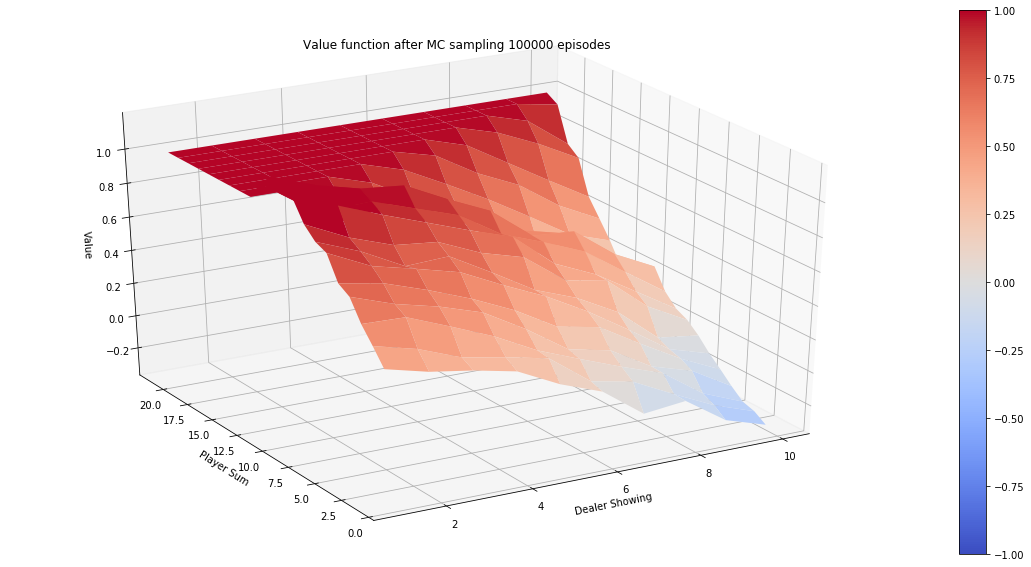

In [18]:
plot_value_function(V, title='Value function after MC sampling %d episodes' % n_episodes)

## 3. TD Learning in Easy21
> Implement Sarsa($\lambda$) in 21s. Initialise the value function to zero. Use the same step-size and exploration schedules as in the previous section. Run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, ..., 1\}$. Stop each run after 1000 episodes and report the mean-squared error $\sum_{s,a}(Q(s, a) − Q*(s, a))^2$ over all states s and actions a, comparing the true values $Q*(s,a)$ computed in the previous section with the estimated values $Q(s, a)$ computed by Sarsa. Plot the mean-squared error against $\lambda$. For $\lambda = 0$ and $\lambda = 1$ only, plot the learning curve of mean-squared error against episode number.